# CST 8502 FINAL PROJECT

By:  
Charles-Antoine Campeau  
Joshua Ayyasamy  
Mubarak husain Shaikh  
Curtis Sloan 

Submitted to Dr. Anu Thomas in partial fulfillment of the requirements of CST 8502 

Algonquin College Artificial Intelligence Software Development

2023-11-26

In [1]:
import pandas as pd
import numpy as np
import math
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics as metrics
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd, numpy as np
from sklearn.preprocessing import label_binarize
from datetime import datetime

## DATA PREPARATION

In [2]:
# Import the CSV
bicycleTheftData = pd.read_csv("bicycle-thefts - 4326.csv")

In [3]:
# Remove the unnecessary attributes
bicycleTheftData = bicycleTheftData.drop(columns=["_id","EVENT_UNIQUE_ID", "OCC_DATE", "OCC_DAY",
                                                   "OCC_DOY", "REPORT_DATE", "REPORT_YEAR", "REPORT_MONTH", "REPORT_DOW", "REPORT_DAY", 
                                                     "REPORT_DOY", "REPORT_HOUR", "LOCATION_TYPE", "BIKE_MODEL", "geometry"])

In [4]:
bicycleTheftData = bicycleTheftData[bicycleTheftData['OCC_YEAR'] == 2022]

In [5]:
bicycleTheftData = bicycleTheftData.drop(columns=["OCC_YEAR"])

## DATA CLEANING & CONSTRUCTION
The data cleaning and construction was separated between all members.  Everyone's contribution is indicated

### Charles

In [6]:
# Import the CSV with the BIKE_MAKE changes
makesData = pd.read_csv("MAKESREPLACEMENT.CSV", delimiter=";")
# Set the index as the good values and convert the strings to list
makesData.set_index("NEW", inplace=True)
makesData["OLD"] = makesData["OLD"].str.split(",")

# Convert the list to a series
makesSeries = makesData["OLD"].explode()

In [7]:
def GetMake(make):
    """Correct wrongfully inputted bicycle makes \n
    Parameter:
    ------------
    make: The instance bicycle make

    Return:
    -----------
    The properly written make
    """
    
    try:
        index = makesSeries.index[makesSeries.str.contains(re.escape(make))][0]
        return index
    except: 
        return make

In [8]:
# Fix the errors in the BIKE_MAKE attribute
bicycleTheftData["BIKE_MAKE"] = bicycleTheftData["BIKE_MAKE"].apply(GetMake)

In [15]:
bicycleTheftData.isnull().sum()

PRIMARY_OFFENCE      0
OCC_MONTH            0
OCC_DOW              0
OCC_HOUR           168
DIVISION             0
PREMISES_TYPE        0
BIKE_MAKE            0
BIKE_TYPE            0
BIKE_SPEED           0
BIKE_COLOUR        269
BIKE_COST            0
STATUS               0
dtype: int64

In [10]:
# Handling Missing values using kNN Imputer
bicycleTheftData[['BIKE_SPEED', 'BIKE_COST']] = KNNImputer().fit_transform(bicycleTheftData[['BIKE_SPEED', 'BIKE_COST']])

In [14]:
e = preprocessing.LabelEncoder()
bicycleTheftData['BIKE_MAKE'] = e.fit_transform(
    bicycleTheftData['BIKE_MAKE'])  # only numerical values for KNNImputer
bicycleTheftData[['BIKE_MAKE']] = KNNImputer().fit_transform(bicycleTheftData[['BIKE_MAKE']])

### Joshua

In [68]:
#bicycleTheftData['BIKE_SPEED'] = bicycleTheftData['BIKE_SPEED'].fillna(bicycleTheftData['BIKE_SPEED'].mean())

In [17]:
low = bicycleTheftData['BIKE_COST'].quantile(.25)
average = bicycleTheftData['BIKE_COST'].quantile(.5)
high = bicycleTheftData['BIKE_COST'].quantile(.75)
bicycleTheftData['BIKE_COST_CATEGORY'] = np.select(
    [
        bicycleTheftData['BIKE_COST'].isna(),
        bicycleTheftData['BIKE_COST'] <= low,
        (bicycleTheftData['BIKE_COST'] > low) & (bicycleTheftData['BIKE_COST'] <= average),
        (bicycleTheftData['BIKE_COST'] > average) & (bicycleTheftData['BIKE_COST'] <= high),
        bicycleTheftData['BIKE_COST'] > high
    ],
    [
        'NK',
        'Low',
        'Average',
        'High',
        'Luxury'
    ],
    default='Unknown'
)


low = bicycleTheftData['BIKE_SPEED'].quantile(.25)
average = bicycleTheftData['BIKE_SPEED'].quantile(.5)
high = bicycleTheftData['BIKE_SPEED'].quantile(.75)
bicycleTheftData['BIKE_SPEED_CATEGORY'] = np.select(
    [
        bicycleTheftData['BIKE_SPEED'].isna(),
        bicycleTheftData['BIKE_SPEED'] <= low,
        (bicycleTheftData['BIKE_SPEED'] > low) & (bicycleTheftData['BIKE_SPEED'] <= average),
        (bicycleTheftData['BIKE_SPEED'] > average) & (bicycleTheftData['BIKE_SPEED'] <= high),
        bicycleTheftData['BIKE_SPEED'] > high
    ],
    [
        'NK',
        'Slow-Speeding',
        'Average-Speeding',
        'Fast-Speeding',
        'Racing'
    ],
    default='Unknown'
)
bicycleTheftData = bicycleTheftData.drop(['BIKE_SPEED'], axis =1)
bicycleTheftData = bicycleTheftData.drop(['BIKE_COST'], axis =1)

In [70]:
#bicycleTheftData['BIKE_MAKE'].fillna('Other', inplace=True) 

### Mubarak

In [18]:
# Replace missing values in PRIMARY_OFFENCE with 'Unknown'
bicycleTheftData['PRIMARY_OFFENCE'].fillna('Unknown', inplace=True)

# Convert entries to lowercase for uniformity
bicycleTheftData['PRIMARY_OFFENCE'] = bicycleTheftData['PRIMARY_OFFENCE'].str.lower()

In [19]:
#there is one instance colored as '18' so to handle such anomalies we will replace it with unknown
bicycleTheftData['BIKE_COLOUR'] = bicycleTheftData['BIKE_COLOUR'].replace('18', 'Unknown')

bicycleTheftData['BIKE_COLOUR'].fillna('Unknown', inplace=True)

In [20]:
# Function to categorize colors
def categorize_color(color):
    color = color.lower()  # Convert to lowercase for uniformity

    color_categories = {
        'black': ['black', 'blk', 'blac'],
        'blue': ['blue', 'blu'],
        'brown': ['brown', 'brn'],
        'beige': ['bge', 'beige'],
        'gold': ['gold', 'gld'],
        'green': ['green', 'grn'],
        'grey': ['grey', 'gray', 'gry'],
        'orange': ['orange', 'ong'],
        'pink': ['pink', 'pnk'],
        'purple': ['purple', 'purp'],
        'red': ['red', 'rd'],
        'silver': ['silver', 'sil'],
        'turquoise': ['turquoise', 'trq'],
        'white': ['white', 'whi'],
        'yellow': ['yellow', 'yel']
       
    }

    for category, values in color_categories.items():
        for value in values:
            if value in color:
                return category

    return 'Unknown'

In [21]:
# Apply the categorize_color function to the BIKE_COLOUR column
bicycleTheftData['BIKE_COLOUR'] = bicycleTheftData['BIKE_COLOUR'].apply(categorize_color)

### Curtis

In [22]:
def month_to_number(data):
    months = ["January", "February", "March","April", "May", "June",
              "July", "August", "September","October", "November", "December"]
    
    if data in months:
        return months.index(data) + 1

bicycleTheftData['OCC_MONTH'] = bicycleTheftData['OCC_MONTH'].apply(month_to_number)

### modified by Joshua 

In [23]:
#keeping only two status i.e. stolen or recovered

#status 0 if the bike stolen
bicycleTheftData['STATUS'].replace('STOLEN', 0, inplace=True)

#status 1 if the bike recovered or unknown
bicycleTheftData['STATUS'].replace(['UNKNOWN', 'RECOVERED'], 1, inplace=True)

In [24]:
#ohe = OneHotEncoder()

#encoded = pd.DataFrame(ohe.fit_transform(bicycleTheftData[['PREMISES_TYPE']]).toarray())
#encoded.columns = ['Apartment','House','Commercial','Outside','Transit','Educational','Other']
#bicycleTheftData = bicycleTheftData.join(encoded)


#encoded = pd.DataFrame(ohe.fit_transform(bicycleTheftData[['BIKE_TYPE']]).toarray())
#encoded.columns = ['BM','EL','FO','MT','OT','RC','RE','RG','SC','TA','TO','TR','UN']
#bicycleTheftData = bicycleTheftData.join(encoded)

In [25]:
def day_to_number(data):
    days = ["Monday", "Tuesday", "Wednesday", "Thursday",
            "Friday", "Saturday", "Sunday"]
    
    if data in days:
        return days.index(data) + 1

bicycleTheftData["OCC_DOW"] = bicycleTheftData["OCC_DOW"].apply(day_to_number)

In [26]:
#bicycleTheftData = bicycleTheftData.drop(['PREMISES_TYPE'], axis=1)
#bicycleTheftData = bicycleTheftData.drop(['BIKE_TYPE'], axis=1)

In [27]:
def time_of_day(data):
    if pd.isnull(data):
        return "Unknown"
    elif data <= 4:
        return "Night"
    elif data <= 8:
        return "Dawn"
    elif data <= 11:
        return "Morning"
    elif data <= 16:
        return "Afternoon"
    elif data <= 21:
        return "Evening"
    else:
        return "Night"
    
bicycleTheftData["OCC_TOD"] = bicycleTheftData["OCC_HOUR"].apply(time_of_day)
bicycleTheftData = bicycleTheftData.drop(['OCC_HOUR'], axis=1)

In [28]:
bicycleTheftData

,PRIMARY_OFFENCE,OCC_MONTH,OCC_DOW,DIVISION,PREMISES_TYPE,BIKE_MAKE,BIKE_TYPE,BIKE_COLOUR,STATUS,BIKE_COST_CATEGORY,BIKE_SPEED_CATEGORY,OCC_TOD
29002,b&e,1,7,D41,House,195.0,MT,Unknown,0,Luxury,Average-Speeding,Afternoon
29006,b&e,1,3,D13,Apartment,215.0,MT,red,0,Luxury,Average-Speeding,Evening
29007,theft under,1,3,D51,Outside,215.0,RG,black,0,High,Slow-Speeding,Evening
29010,theft under - bicycle,1,3,D55,House,207.0,MT,grey,0,Luxury,Average-Speeding,Night
29011,theft under - bicycle,1,5,D32,House,215.0,MT,black,0,Luxury,Fast-Speeding,Evening
...,...,...,...,...,...,...,...,...,...,...,...,...
31965,theft of ebike under $5000,12,4,D53,Outside,229.0,TO,black,0,Luxury,Fast-Speeding,Evening
31966,theft of ebike under $5000,12,3,D52,Outside,215.0,EL,black,0,High,Slow-Speeding,Night
31967,theft under - bicycle,10,6,D23,Other,23.0,RG,blue,0,High,Racing,Afternoon
31968,theft under,12,5,D11,Outside,23.0,RG,Unknown,0,Luxury,Average-Speeding,Morning


# One hot encoding of the categorical data

In [29]:
encoder = preprocessing.LabelEncoder()
categoricalData = [col for col in bicycleTheftData.columns if bicycleTheftData[col].dtype == 'object']
for col in categoricalData:
    bicycleTheftData[col] = encoder.fit_transform(bicycleTheftData[col])

In [30]:
bicycleTheftData

,PRIMARY_OFFENCE,OCC_MONTH,OCC_DOW,DIVISION,PREMISES_TYPE,BIKE_MAKE,BIKE_TYPE,BIKE_COLOUR,STATUS,BIKE_COST_CATEGORY,BIKE_SPEED_CATEGORY,OCC_TOD
29002,1,1,7,9,3,195.0,3,0,0,3,0,0
29006,1,1,3,2,0,215.0,3,10,0,3,0,2
29007,27,1,3,12,5,215.0,7,2,0,1,3,2
29010,28,1,3,15,3,207.0,3,7,0,3,0,4
29011,28,1,5,7,3,215.0,3,2,0,3,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...
31965,23,12,4,14,5,229.0,10,2,0,3,1,2
31966,23,12,3,13,5,215.0,1,2,0,1,3,4
31967,28,10,6,5,4,23.0,7,3,0,1,2,0
31968,27,12,5,0,5,23.0,7,0,0,3,0,3


### Looking at the question, we have to classify the data according to the TYPE of the bike stolen, AREA of the stolen bike and the TIMING of the stolen bike, hence in this case we will be having BIKE_TYPE,  PREMISES_TYPE and OCC_TOD as the labels

### for the type of bike stolen classifying into training and the test sets

In [87]:
#X, Y = bicycleTheftData.drop('PREMISES_TYPE', axis=1), bicycleTheftData['PREMISES_TYPE']
#x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.2)

In [84]:
#X, Y = bicycleTheftData['STATUS'], bicycleTheftData['PREMISES_TYPE']
#x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.2)

In [109]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#from imblearn.ensemble import BalancedBaggingClassifier

# Assuming X is your feature matrix and y is your target vector
X, Y = bicycleTheftData.drop('STATUS', axis=1), bicycleTheftData['STATUS']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


# kNN model

In [110]:
scaler = StandardScaler()
scaler.fit(X_train)
x_train = scaler.transform(X_train)
x_test = scaler.transform(X_test)

In [119]:
# Model fitting with K-cross Validation and GridSearchCV
k_range = list(range(1, 11))
param_grid = dict(n_neighbors=k_range)

# Fine Tuning- defining parameter range for GridSearch kernel
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy',
                    return_train_score=False, verbose=1)

# fitting the model for grid search
grid_search = grid.fit(x_train, y_train)

# best parameters & estimator
print("Best Params: ", grid_search.best_params_)
print("Best estimators are: ", grid_search.best_estimator_)


accuracy = grid_search.best_score_ * 100
print(
    "Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy))




Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Params:  {'n_neighbors': 3}
Best estimators are:  KNeighborsClassifier(n_neighbors=3)
Accuracy for our training dataset with tuning is : 98.67%


In [120]:
# Training the KNN Classification model on the Training Set with best param

classifier = KNeighborsClassifier(n_neighbors = 3)
classifier.fit(x_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(x_test)

# predict_proba to return numpy array with two columns for a binary classification for N and P
y_scores = classifier.predict_proba(x_test)


print('Classification Report(N): \n', classification_report(y_test, y_pred))
print('Confusion Matrix(N): \n', confusion_matrix(y_test, y_pred))
print('Accuracy(N): ', metrics.accuracy_score(y_test, y_pred))

# Comparing the Real Values with Predicted Values
df = pd.DataFrame({'Real Values': y_test, 'Predicted Values': y_pred})
print(df)


Classification Report(N): 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       575
           1       1.00      0.20      0.33        10

    accuracy                           0.99       585
   macro avg       0.99      0.60      0.66       585
weighted avg       0.99      0.99      0.98       585

Confusion Matrix(N): 
 [[575   0]
 [  8   2]]
Accuracy(N):  0.9863247863247864
       Real Values  Predicted Values
30093            0                 0
31441            0                 0
30173            0                 0
30438            0                 0
29724            0                 0
...            ...               ...
29730            0                 0
29736            0                 0
31683            0                 0
30224            0                 0
31487            0                 0

[585 rows x 2 columns]


## kNN using a different approach

k= 3
Classification Report(N): 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       575
           1       1.00      0.20      0.33        10

    accuracy                           0.99       585
   macro avg       0.99      0.60      0.66       585
weighted avg       0.99      0.99      0.98       585

Confusion Matrix(N): 
 [[575   0]
 [  8   2]]
Accuracy: 0.9863247863247864
       Real Values  Predicted Values
30093            0                 0
31441            0                 0
30173            0                 0
30438            0                 0
29724            0                 0
...            ...               ...
29730            0                 0
29736            0                 0
31683            0                 0
30224            0                 0
31487            0                 0

[585 rows x 2 columns]


Text(0, 0.5, 'Accuracy Score')

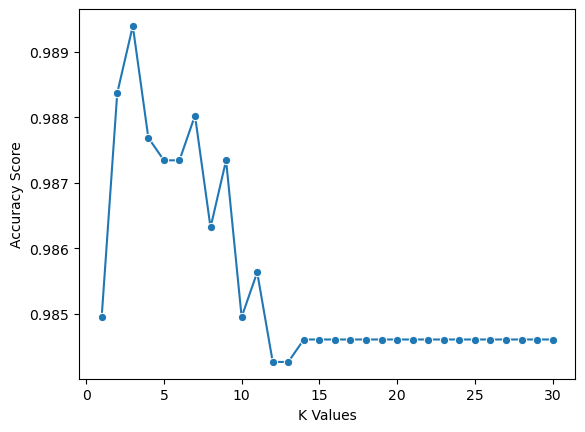

In [118]:
scaler = StandardScaler()

k_values = [i for i in range (1,31)]
scores = []

scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, Y, cv=10)
    scores.append(np.mean(score))

best_index = np.argmax(scores)
best_k = k_values[best_index]
print("k=", best_k)
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(x_train, y_train)

y_pred = knn.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
#precision = precision_score(y_test, y_pred)
#recall = recall_score(y_test, y_pred)
print('Classification Report(N): \n', classification_report(y_test, y_pred))
print('Confusion Matrix(N): \n', confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy)
#print("Precision:", precision)
#print("Recall:", recall)

df = pd.DataFrame({'Real Values': y_test, 'Predicted Values': y_pred})
print(df)

sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")